In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [109]:
df_sentiment = pd.read_csv("./Topic Modelling per Sentence/The_Kingmaker/sentence_sentiment_results.csv")
df_reviews = pd.read_csv("./Sentiment Analysis CSV/the_kingmaker_reviews_sentiment.csv")

In [110]:
# Create emotion mapping based on the image logic
# In the image: negative → multiply by 2, positive → multiply by 1
emotion_map = {'positive': 1, 'negative': -2}  # Changed from -2 to 2
df_sentiment['emotion'] = df_sentiment['sentiment_label'].map(emotion_map).fillna(0)

# Calculate x value: sentiment_score * emotion_multiplier
df_sentiment['x'] = df_sentiment['sentiment_score'] * df_sentiment['emotion']

# Group by review_index to calculate sum of x values and count sentences
results_df = df_sentiment.groupby('review_index').agg(
    sum_score=('x', 'sum'),
    num_sentences=('sentence_index', 'count')
).reset_index()

# Apply the formula from the image: 50 + (50 / num_sentences * sum_score)
# IMPORTANT: The image uses absolute values for negative scores (hence *2 for negatives)
results_df['avg_sentiment'] = abs(50 + (50 / results_df['num_sentences'] * results_df['sum_score']))

# Display results
print("Results DataFrame:")
print(results_df)
print(f"\nNumber of reviews processed: {len(results_df)}")

# Example calculation to verify with the image
print("\nExample calculation for review_index 0 (from image):")
review_0 = df_sentiment[df_sentiment['review_index'] == 0]
print(f"Sentences in review 0: {len(review_0)}")
print("Calculating using image formula:")

# Manually calculate to verify
if len(review_0) > 0:
    sum_x = review_0['x'].sum()
    num_sent = len(review_0)
    calculated = 50 + (50 / num_sent * sum_x)
    print(f"sum_x = {sum_x}")
    print(f"num_sentences = {num_sent}")
    print(f"50 + (50 / {num_sent} * {sum_x}) = {calculated}")
    print(f"Result from DataFrame: {results_df.loc[0, 'avg_sentiment']}")

# Merge avg_sentiment into df_sentiment and rename it to nmd_score
df_sentiment = df_sentiment.merge(
    results_df[['review_index', 'avg_sentiment', 'num_sentences']], 
    on='review_index', 
    how='left'
)

# Rename 'avg_sentiment' to 'nmd_score' to match what you want
df_sentiment = df_sentiment.rename(columns={'avg_sentiment': 'nmd_score'})

# Prepare reviews data
df_reviews = df_reviews.rename(columns={'review_id': 'review_index', 'sentence_num': 'sentence_num_original'})
df_reviews['sentence_index'] = df_reviews['sentence_num_original'] - 1

# Merge the two dataframes
df_combined = pd.merge(
    df_sentiment,
    df_reviews[['review_index', 'sentence_index', 'username', 'date', 'rating', 'source']],
    on=['review_index', 'sentence_index'],
    how='inner'
)

# Create a summary dataframe with one row per review
review_summary = df_combined.groupby('review_index').agg({
    'username': 'first',
    'date': 'first',
    'rating': 'first',
    'source': 'first',
    'nmd_score': 'first',
    'num_sentences': 'first'  # This already exists from the merge
}).reset_index()

# Rename columns for clarity
review_summary = review_summary.rename(columns={
    'rating': 'user_rating',
    'date': 'review_date'
})

# Add the original metrics from results_df
review_summary = review_summary.merge(
    results_df[['review_index', 'sum_score']],
    on='review_index',
    how='left'
)

# Calculate additional metrics from sentiment data
sentiment_stats = df_sentiment.groupby('review_index').agg({
    'sentiment_score': 'mean',
    'sentiment_label': lambda x: (x == 'positive').mean() * 100
}).reset_index()

sentiment_stats = sentiment_stats.rename(columns={
    'sentiment_score': 'avg_sentiment_score',
    'sentiment_label': 'positive_percentage'
})

# Merge the sentiment stats
review_summary = review_summary.merge(sentiment_stats, on='review_index', how='left')

# Reorder columns for better presentation
review_summary = review_summary[[
    'review_index', 'username', 'review_date', 'user_rating', 'source',
    'num_sentences', 'sum_score', 'nmd_score', 
    'avg_sentiment_score', 'positive_percentage'
]]

print("\n" + "="*80)
print("COMBINED REVIEW SUMMARY (one row per review):")
print("="*80)
print(review_summary.to_string())

print("\n" + "="*80)
print("DETAILED COMBINED DATA (all sentences):")
print("="*80)
print(df_combined[['review_index', 'sentence_index', 'username', 'date', 
                   'rating', 'source', 'sentiment_label', 'sentiment_score', 
                   'nmd_score', 'sentence_text']].head(10).to_string())

# Verification
print("\n" + "="*80)
print("FORMULA VERIFICATION FOR FIRST REVIEW:")
print("="*80)
first_review = review_summary.iloc[0]
print(f"Review Index: {first_review['review_index']}")
print(f"sum_score: {first_review['sum_score']:.6f}")
print(f"num_sentences: {first_review['num_sentences']}")
print(f"Manual calculation: 100/{first_review['num_sentences']} × {first_review['sum_score']:.6f}")
print(f"  = {100/first_review['num_sentences']} × {first_review['sum_score']:.6f}")
print(f"  = {100/first_review['num_sentences'] * first_review['sum_score']:.6f}")
print(f"nmd_score in DataFrame: {first_review['nmd_score']:.6f}")

Results DataFrame:
      review_index  sum_score  num_sentences  avg_sentiment
0                0   2.294026              5      72.940263
1                1  -0.300299              5      46.997011
2                2   1.479862              4      68.498277
3                3   1.477292              4      68.466151
4                4   2.888182              6      74.068181
...            ...        ...            ...            ...
1485          1543   0.964074              1      98.203698
1486          1544   0.974241              1      98.712063
1487          1545   0.971806              1      98.590323
1488          1546   0.895260              1      94.763002
1489          1547   0.755125              1      87.756240

[1490 rows x 4 columns]

Number of reviews processed: 1490

Example calculation for review_index 0 (from image):
Sentences in review 0: 5
Calculating using image formula:
sum_x = 2.294026255607605
num_sentences = 5
50 + (50 / 5 * 2.294026255607605) = 72.940262

In [111]:
import os

# Create the directory if it doesn't exist
output_dir = './Narrative-Metric Disconnect/The Kingmaker'
os.makedirs(output_dir, exist_ok=True)

# Export the two main dataframes
review_summary.to_csv(os.path.join(output_dir, 'review_summary.csv'), index=False)
df_combined.to_csv(os.path.join(output_dir, 'detailed_sentiment_data.csv'), index=False)

print(f"Files exported to: {output_dir}")
print(f"1. review_summary.csv ({len(review_summary)} reviews)")
print(f"2. detailed_sentiment_data.csv ({len(df_combined)} sentences)")

Files exported to: ./Narrative-Metric Disconnect/The Kingmaker
1. review_summary.csv (1464 reviews)
2. detailed_sentiment_data.csv (4277 sentences)


In [112]:
df_nmd = pd.read_csv("./Narrative-Metric Disconnect/The Kingmaker/detailed_sentiment_data.csv")

Creating line charts with fixed y-axis range (0-100) with space after 100...
FIXED: Missing data gaps are now filled to prevent broken lines.


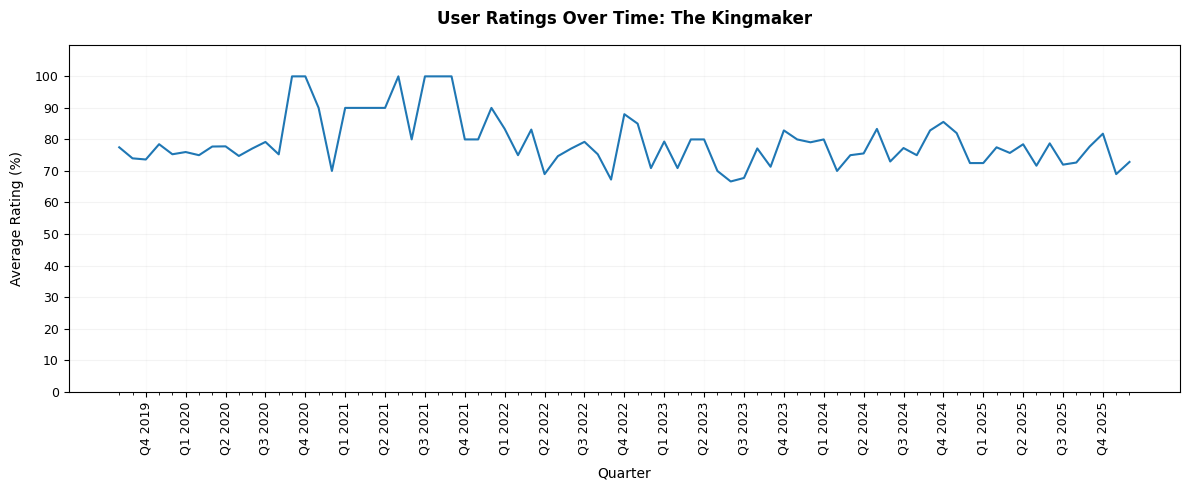


User Ratings Timeline for 'The Kingmaker':
Time period: Aug 2019 to Dec 2025
Overall average: 76.4%
Y-axis range: 0 to 100%


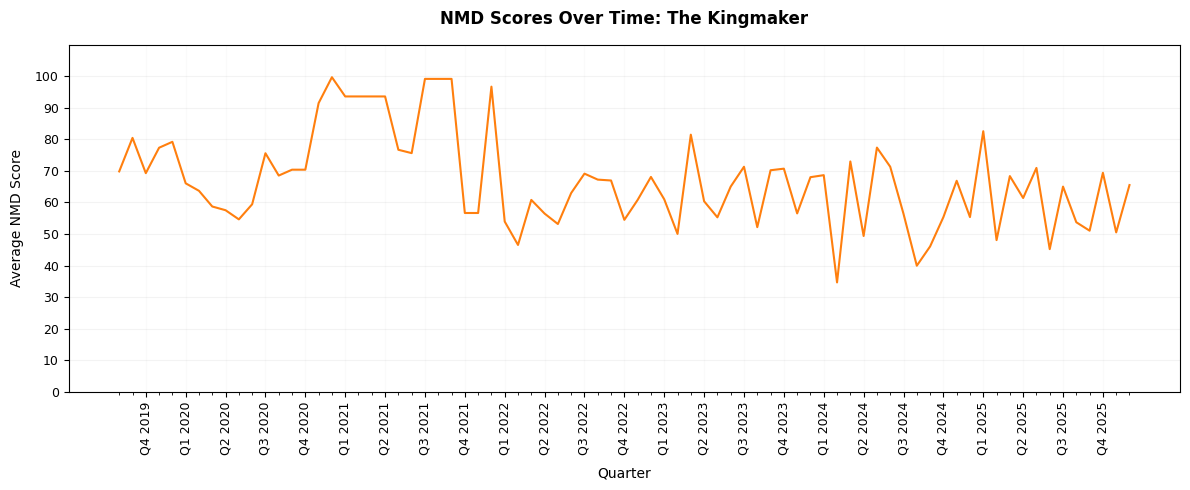


NMD Scores Timeline for 'The Kingmaker':
Time period: Aug 2019 to Dec 2025
Overall average: 62.24
Y-axis range: 0 to 100


In [113]:
def create_rating_line_graph(df, movie_name):
    """
    Create a simple line graph showing user ratings over time (by month)
    Based on the provided template design
    """
    # Ensure date is datetime
    if 'review_date' in df.columns:
        df['date'] = df['review_date']
    
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by month and calculate average rating
    df['month'] = df['date'].dt.to_period('M')
    ratings_by_month = df.groupby('month')['user_rating'].mean()
    
    # Convert to dataframe for plotting
    ratings_by_month_df = ratings_by_month.reset_index()
    ratings_by_month_df.columns = ['month', 'avg_rating']
    
    # Convert period to datetime for better formatting
    ratings_by_month_df['month_datetime'] = ratings_by_month_df['month'].dt.to_timestamp()
    
    # Create a complete date range from min to max month
    if len(ratings_by_month_df) > 0:
        min_date = ratings_by_month_df['month_datetime'].min()
        max_date = ratings_by_month_df['month_datetime'].max()
        
        # Generate all months between min and max
        all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
        all_months_period = all_months.to_period('M')
        
        # Create a dataframe with all months
        all_months_df = pd.DataFrame({
            'month': all_months_period,
            'month_datetime': all_months
        })
        
        # Merge with actual data, filling missing months with NaN
        complete_df = pd.merge(all_months_df, ratings_by_month_df, 
                              on=['month', 'month_datetime'], 
                              how='left')
        
        # Update ratings_by_month_df to include all months
        ratings_by_month_df = complete_df
    
    # Create formatted month names
    ratings_by_month_df['month_name'] = ratings_by_month_df['month_datetime'].dt.strftime('%b %Y')
    ratings_by_month_df['year'] = ratings_by_month_df['month_datetime'].dt.year
    ratings_by_month_df['month_num'] = ratings_by_month_df['month_datetime'].dt.month
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Plot WITHOUT markers (dots) - just the line
    x_positions = range(len(ratings_by_month_df))
    
    # Create a copy for plotting that connects gaps
    plot_data = ratings_by_month_df['avg_rating'].copy()
    
    # FIX: Fill NaN values with forward fill then backward fill to handle gaps
    # This will connect the line even if there are missing months
    plot_data_filled = plot_data.copy()
    
    # First forward fill (carry last known value forward)
    plot_data_filled = plot_data_filled.ffill()
    
    # Then backward fill (carry first known value backward)
    plot_data_filled = plot_data_filled.bfill()
    
    # If all values are NaN after filling (edge case), use linear interpolation
    if plot_data_filled.isna().all():
        plot_data_filled = plot_data.interpolate(method='linear')
    
    # Plot the line - using the filled data to avoid breaks
    plt.plot(x_positions, 
             plot_data_filled, 
             marker='o',
             linestyle='-',
             linewidth=1.5,
             markersize=0,
             markeredgewidth=0,
             color='#1f77b4')
    
    # Determine x-axis label display
    num_months = len(ratings_by_month_df)
    
    if num_months > 12:
        # Create quarterly labels
        quarterly_positions = []
        quarterly_labels = []
        
        # Get unique years sorted
        years = sorted(ratings_by_month_df['year'].unique())
        
        for year in years:
            # For each year, show Q1, Q2, Q3, Q4 at quarter starts (Jan, Apr, Jul, Oct)
            year_data = ratings_by_month_df[ratings_by_month_df['year'] == year]
            
            # Find positions for each quarter start
            for quarter, start_month in enumerate([1, 4, 7, 10], 1):
                quarter_data = year_data[year_data['month_num'] == start_month]
                if not quarter_data.empty:
                    idx = quarter_data.index[0]
                    quarterly_positions.append(idx)
                    quarterly_labels.append(f"Q{quarter} {year}")
        
        # Check if the last two labels are the same
        if len(quarterly_labels) >= 2:
            # Check if last two labels are the same quarter/year
            last_label = quarterly_labels[-1]
            second_last_label = quarterly_labels[-2]
            
            # If they're the same, remove the last one
            if last_label == second_last_label:
                quarterly_positions = quarterly_positions[:-1]
                quarterly_labels = quarterly_labels[:-1]
        
        # Only add last position if it's not already included AND it's different from existing
        last_idx = len(ratings_by_month_df) - 1
        if last_idx not in quarterly_positions and len(quarterly_positions) > 0:
            last_row = ratings_by_month_df.iloc[-1]
            last_year = last_row['year']
            last_month = last_row['month_num']
            
            if last_month <= 3:
                last_quarter = 1
            elif last_month <= 6:
                last_quarter = 2
            elif last_month <= 9:
                last_quarter = 3
            else:
                last_quarter = 4
            
            last_quarter_label = f"Q{last_quarter} {last_year}"
            
            # Check if this label is different from the last existing label
            if not quarterly_labels or last_quarter_label != quarterly_labels[-1]:
                quarterly_positions.append(last_idx)
                quarterly_labels.append(last_quarter_label)
        
        # Set x-ticks
        ax = plt.gca()
        ax.set_xticks(quarterly_positions)
        ax.set_xticklabels(quarterly_labels, rotation=90, ha='center', fontsize=9)
        
        # Set minor ticks for all positions to maintain x-grid
        ax.set_xticks(x_positions, minor=True)
        
    else:
        # Show all months for 12 months or fewer
        plt.xticks(x_positions, ratings_by_month_df['month_name'], 
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis for ratings - FIXED: Always use 0-100 range with space after 100
    plt.ylim(0, 110)  # Changed to 110 to add space after 100
    
    # Set y-ticks from 0 to 100 with step of 10 (don't show 110 on the axis)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add a subtle zero line
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Title and labels
    plt.title(f'User Ratings Over Time: {movie_name}', fontsize=12, fontweight='bold', pad=15)
    plt.xlabel('Quarter' if num_months > 12 else 'Month', fontsize=10, labelpad=8)
    plt.ylabel('Average Rating (%)', fontsize=10, labelpad=8)
    
    # Grid and layout
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.05, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nUser Ratings Timeline for '{movie_name}':")
    print(f"Time period: {ratings_by_month_df['month_name'].iloc[0]} to {ratings_by_month_df['month_name'].iloc[-1]}")
    print(f"Overall average: {df['user_rating'].mean():.1f}%")
    print(f"Y-axis range: 0 to 100%")


def create_nmd_line_graph(df, movie_name):
    """
    Create a simple line graph showing NMD scores over time (by month)
    Based on the provided template design
    """
    # Ensure date is datetime
    if 'review_date' in df.columns:
        df['date'] = df['review_date']
    
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by month and calculate average NMD
    df['month'] = df['date'].dt.to_period('M')
    nmd_by_month = df.groupby('month')['nmd_score'].mean()
    
    # Convert to dataframe for plotting
    nmd_by_month_df = nmd_by_month.reset_index()
    nmd_by_month_df.columns = ['month', 'avg_nmd']
    
    # Convert period to datetime for better formatting
    nmd_by_month_df['month_datetime'] = nmd_by_month_df['month'].dt.to_timestamp()
    
    # Create a complete date range from min to max month
    if len(nmd_by_month_df) > 0:
        min_date = nmd_by_month_df['month_datetime'].min()
        max_date = nmd_by_month_df['month_datetime'].max()
        
        # Generate all months between min and max
        all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
        all_months_period = all_months.to_period('M')
        
        # Create a dataframe with all months
        all_months_df = pd.DataFrame({
            'month': all_months_period,
            'month_datetime': all_months
        })
        
        # Merge with actual data, filling missing months with NaN
        complete_df = pd.merge(all_months_df, nmd_by_month_df, 
                              on=['month', 'month_datetime'], 
                              how='left')
        
        # Update nmd_by_month_df to include all months
        nmd_by_month_df = complete_df
    
    # Create formatted month names
    nmd_by_month_df['month_name'] = nmd_by_month_df['month_datetime'].dt.strftime('%b %Y')
    nmd_by_month_df['year'] = nmd_by_month_df['month_datetime'].dt.year
    nmd_by_month_df['month_num'] = nmd_by_month_df['month_datetime'].dt.month
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Plot WITHOUT markers (dots) - just the line
    x_positions = range(len(nmd_by_month_df))
    
    # Create a copy for plotting that connects gaps
    plot_data = nmd_by_month_df['avg_nmd'].copy()
    
    # FIX: Fill NaN values with forward fill then backward fill to handle gaps
    # This will connect the line even if there are missing months
    plot_data_filled = plot_data.copy()
    
    # First forward fill (carry last known value forward)
    plot_data_filled = plot_data_filled.ffill()
    
    # Then backward fill (carry first known value backward)
    plot_data_filled = plot_data_filled.bfill()
    
    # If all values are NaN after filling (edge case), use linear interpolation
    if plot_data_filled.isna().all():
        plot_data_filled = plot_data.interpolate(method='linear')
    
    # Plot the line - using the filled data to avoid breaks
    plt.plot(x_positions, 
             plot_data_filled, 
             marker='o',
             linestyle='-',
             linewidth=1.5,
             markersize=0,
             markeredgewidth=0,
             color='#ff7f0e')  # Orange color for NMD
    
    
    # Determine x-axis label display
    num_months = len(nmd_by_month_df)
    
    if num_months > 12:
        # Create quarterly labels
        quarterly_positions = []
        quarterly_labels = []
        
        # Get unique years sorted
        years = sorted(nmd_by_month_df['year'].unique())
        
        for year in years:
            # For each year, show Q1, Q2, Q3, Q4 at quarter starts (Jan, Apr, Jul, Oct)
            year_data = nmd_by_month_df[nmd_by_month_df['year'] == year]
            
            # Find positions for each quarter start
            for quarter, start_month in enumerate([1, 4, 7, 10], 1):
                quarter_data = year_data[year_data['month_num'] == start_month]
                if not quarter_data.empty:
                    idx = quarter_data.index[0]
                    quarterly_positions.append(idx)
                    quarterly_labels.append(f"Q{quarter} {year}")
        
        # Check if the last two labels are the same
        if len(quarterly_labels) >= 2:
            # Check if last two labels are the same quarter/year
            last_label = quarterly_labels[-1]
            second_last_label = quarterly_labels[-2]
            
            # If they're the same, remove the last one
            if last_label == second_last_label:
                quarterly_positions = quarterly_positions[:-1]
                quarterly_labels = quarterly_labels[:-1]
        
        # Only add last position if it's not already included AND it's different from existing
        last_idx = len(nmd_by_month_df) - 1
        if last_idx not in quarterly_positions and len(quarterly_positions) > 0:
            last_row = nmd_by_month_df.iloc[-1]
            last_year = last_row['year']
            last_month = last_row['month_num']
            
            if last_month <= 3:
                last_quarter = 1
            elif last_month <= 6:
                last_quarter = 2
            elif last_month <= 9:
                last_quarter = 3
            else:
                last_quarter = 4
            
            last_quarter_label = f"Q{last_quarter} {last_year}"
            
            # Check if this label is different from the last existing label
            if not quarterly_labels or last_quarter_label != quarterly_labels[-1]:
                quarterly_positions.append(last_idx)
                quarterly_labels.append(last_quarter_label)
        
        # Set x-ticks
        ax = plt.gca()
        ax.set_xticks(quarterly_positions)
        ax.set_xticklabels(quarterly_labels, rotation=90, ha='center', fontsize=9)
        
        # Set minor ticks for all positions to maintain x-grid
        ax.set_xticks(x_positions, minor=True)
        
    else:
        # Show all months for 12 months or fewer
        plt.xticks(x_positions, nmd_by_month_df['month_name'], 
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis for NMD scores - FIXED: Always use 0-100 range with space after 100
    plt.ylim(0, 110)  # Changed to 110 to add space after 100
    
    # Set y-ticks from 0 to 100 with step of 10 (don't show 110 on the axis)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add a subtle zero line
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Title and labels
    plt.title(f'NMD Scores Over Time: {movie_name}', fontsize=12, fontweight='bold', pad=15)
    plt.xlabel('Quarter' if num_months > 12 else 'Month', fontsize=10, labelpad=8)
    plt.ylabel('Average NMD Score', fontsize=10, labelpad=8)
    
    # Grid and layout
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.05, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nNMD Scores Timeline for '{movie_name}':")
    print(f"Time period: {nmd_by_month_df['month_name'].iloc[0]} to {nmd_by_month_df['month_name'].iloc[-1]}")
    print(f"Overall average: {df['nmd_score'].mean():.2f}")
    print(f"Y-axis range: 0 to 100")


# Create both charts
print("Creating line charts with fixed y-axis range (0-100) with space after 100...")
print("FIXED: Missing data gaps are now filled to prevent broken lines.")

# Ensure we have the date column in review_summary
if 'review_date' in review_summary.columns:
    review_summary = review_summary.rename(columns={'review_date': 'date'})
elif 'date' not in review_summary.columns:
    # Check for alternative date columns
    for col in ['Date', 'DATE', 'review_date', 'Review_Date']:
        if col in review_summary.columns:
            review_summary = review_summary.rename(columns={col: 'date'})
            break

# Create ratings chart (with fixed 0-100 range and space after 100)
create_rating_line_graph(review_summary.copy(), "The Kingmaker")

# Create NMD chart (with fixed 0-100 range and space after 100)
create_nmd_line_graph(review_summary.copy(), "The Kingmaker")

DAILY USER RATINGS SCATTERPLOT (NO MONTH GROUPING)


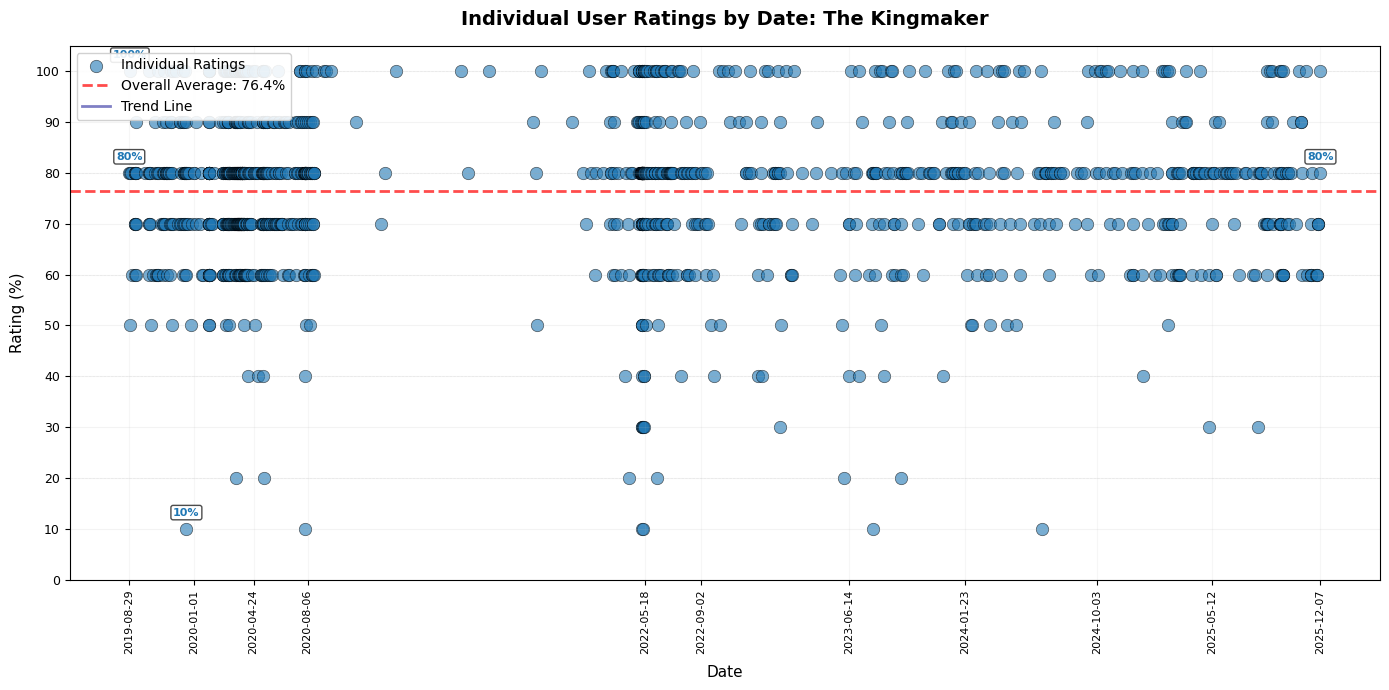


Individual Ratings Scatterplot (Daily) for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total days with reviews: 701
Total reviews: 1464
Overall average rating: 76.4%
Rating range: 10% to 100%
Trend slope: nan (positive = increasing over time)

DAILY NMD SCORES SCATTERPLOT (NO MONTH GROUPING)


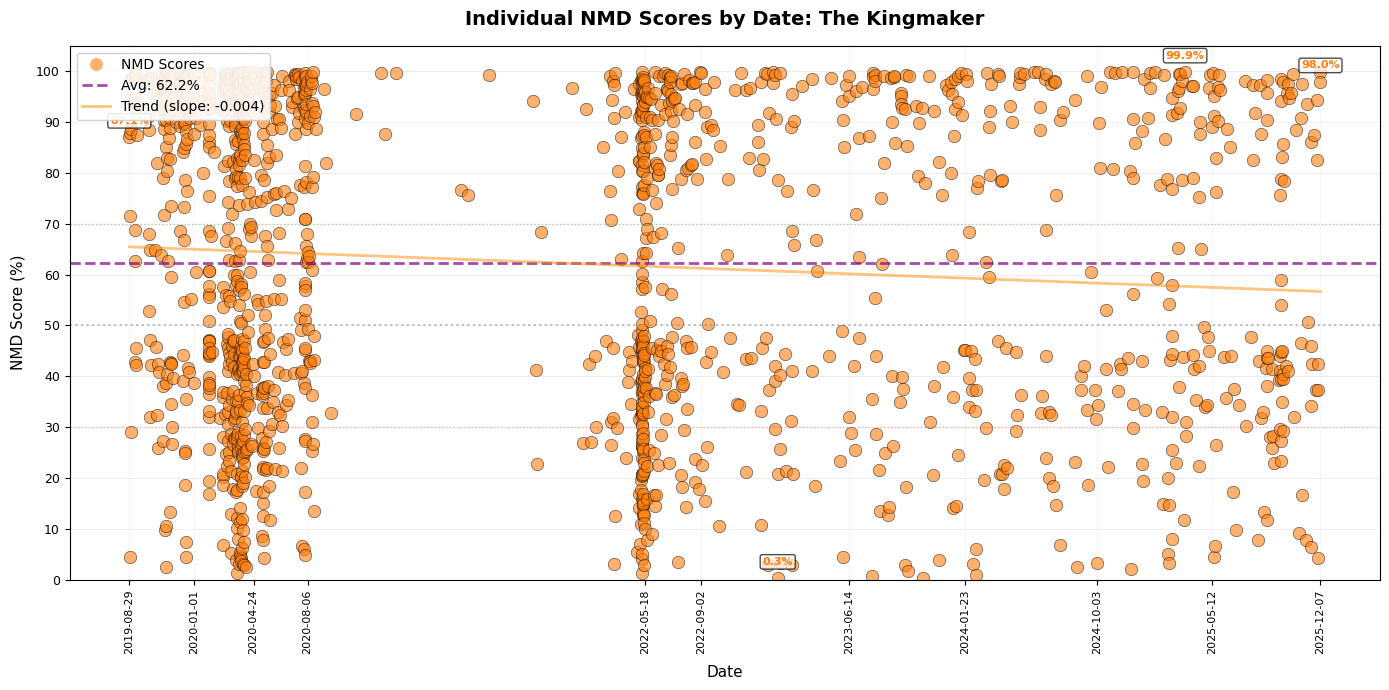


Individual NMD Scores Scatterplot (Daily) for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total days with reviews: 701
Total reviews: 1464
Overall average NMD: 62.24%
NMD range: 0.31% to 99.90%
Trend slope: -0.0038 (positive = NMD increasing over time)

DAILY COMBINED SCATTERPLOTS


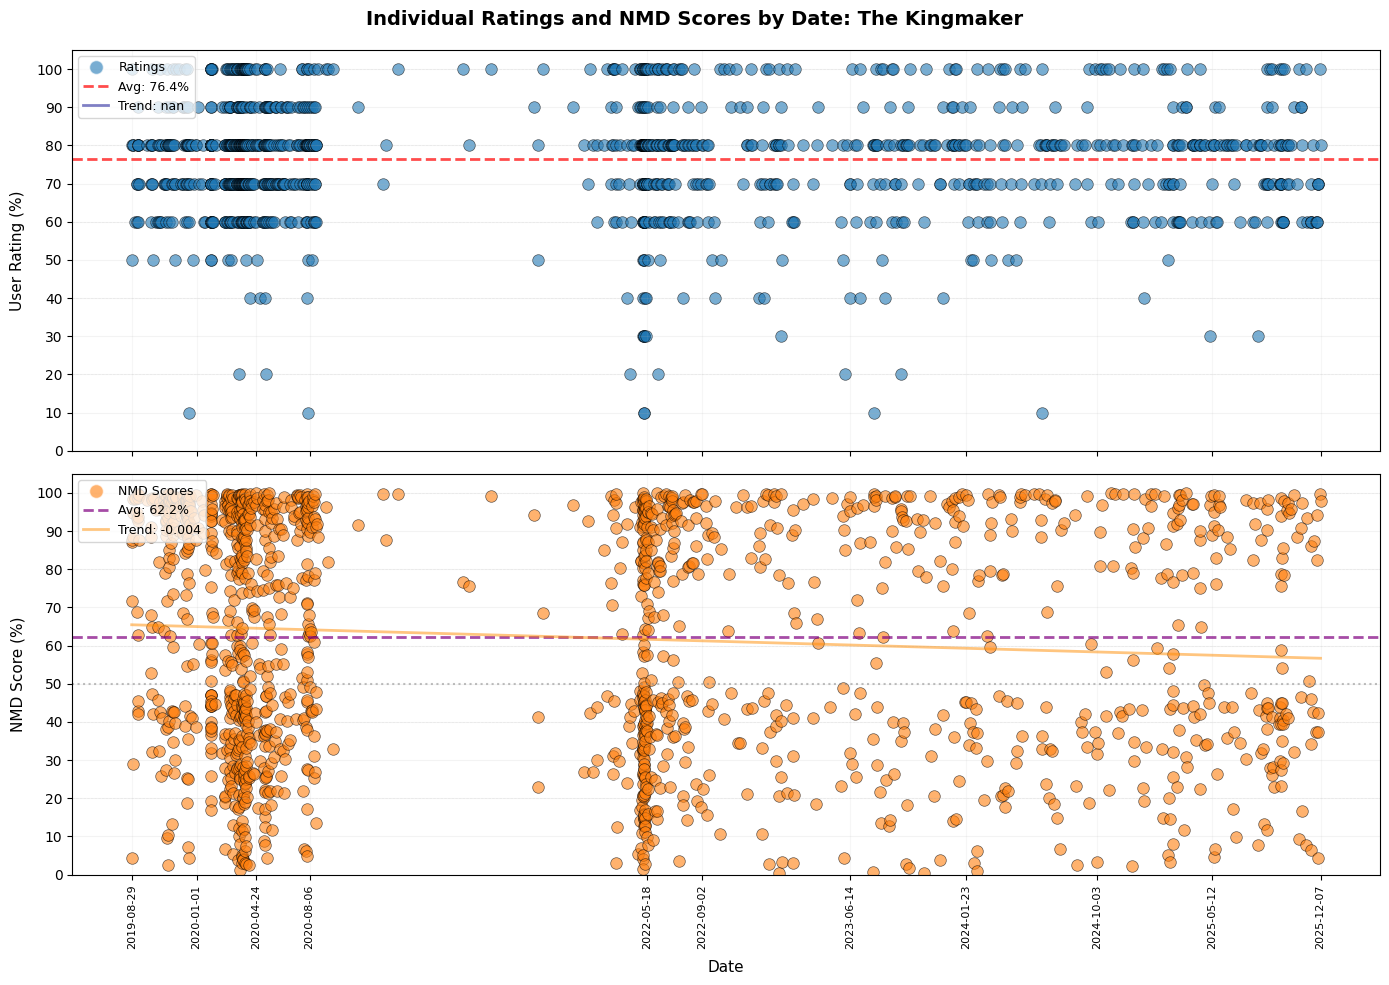


Daily Combined Analysis for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total reviews: 1464
Total days with reviews: 701
Average user rating: 76.4% (trend: nan)
Average NMD score: 62.24% (trend: -0.0038)
Correlation between rating and NMD: 0.060
Interpretation: Weak or no correlation


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def create_rating_scatterplot_daily(df, movie_name):
    """
    Create a scatterplot showing individual user ratings over time (daily)
    Each point is an individual review/rating on its actual date
    """
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Check for rating column
    rating_col = 'rating' if 'rating' in df.columns else 'user_rating'
    
    # Ensure date is datetime
    if 'date' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'])
    else:
        print("Error: No 'date' column found in the data")
        print(f"Available columns: {list(df.columns)}")
        return
    
    # Group by review_index to get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        rating_col: 'first',
        'nmd_score': 'mean'
    }).reset_index()
    
    # Sort by date
    unique_reviews = unique_reviews.sort_values('date')
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Convert dates to numeric values for x-axis (days since first date)
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add small jitter to prevent overlapping points on same date
    np.random.seed(42)
    jitter_amount = 0.3  # Days of jitter
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Create scatter plot
    scatter = plt.scatter(unique_reviews['x_jittered'], 
                         unique_reviews[rating_col],
                         s=80,
                         c='#1f77b4',
                         alpha=0.6,
                         edgecolors='black',
                         linewidth=0.5,
                         label='Individual Ratings')
    
    # Add horizontal line for overall average
    overall_avg = unique_reviews[rating_col].mean()
    plt.axhline(y=overall_avg, 
                color='red', 
                linestyle='--', 
                linewidth=2,
                alpha=0.7,
                label=f'Overall Average: {overall_avg:.1f}%')
    
    # Add trend line
    z = np.polyfit(unique_reviews['date_numeric'], unique_reviews[rating_col], 1)
    p = np.poly1d(z)
    plt.plot(unique_reviews['date_numeric'].sort_values(), 
             p(unique_reviews['date_numeric'].sort_values()),
             color='darkblue',
             linestyle='-',
             linewidth=2,
             alpha=0.5,
             label='Trend Line')
    
    # Label some key points
    if len(unique_reviews) <= 30:
        # Label all points if there are few
        for i, row in unique_reviews.iterrows():
            plt.annotate(f'{row[rating_col]:.0f}%', 
                        (row['x_jittered'], row[rating_col]),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=7,
                        color='#1f77b4')
    else:
        # Label first, last, min, max, and every Nth point
        first_idx = unique_reviews.index[0]
        last_idx = unique_reviews.index[-1]
        min_idx = unique_reviews[rating_col].idxmin()
        max_idx = unique_reviews[rating_col].idxmax()
        
        for idx in [first_idx, last_idx, min_idx, max_idx]:
            row = unique_reviews.loc[idx]
            plt.annotate(f'{row[rating_col]:.0f}%', 
                        (row['x_jittered'], row[rating_col]),
                        xytext=(0, 8),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='#1f77b4',
                        bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor="white", 
                                alpha=0.7))
    
    # Set up x-axis with actual dates
    # Get unique dates for labeling
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    
    # Convert to numeric positions
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    
    # Format date labels
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    # Determine label frequency
    num_dates = len(date_labels)
    if num_dates > 20:
        # Show every 3rd date label
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        plt.xticks([date_numeric_positions[i] for i in show_indices],
                   [date_label_strings[i] for i in show_indices],
                   rotation=90, ha='center', fontsize=8)
    else:
        # Show all dates
        plt.xticks(date_numeric_positions, date_label_strings,
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis
    plt.ylim(0, 105)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add grid
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.1, axis='x')
    
    # Add reference lines
    for y in [20, 40, 60, 80, 100]:
        plt.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Add legend
    plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # Title and labels
    plt.title(f'Individual User Ratings by Date: {movie_name}', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Date', fontsize=11, labelpad=8)
    plt.ylabel('Rating (%)', fontsize=11, labelpad=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nIndividual Ratings Scatterplot (Daily) for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Overall average rating: {overall_avg:.1f}%")
    print(f"Rating range: {unique_reviews[rating_col].min():.0f}% to {unique_reviews[rating_col].max():.0f}%")
    print(f"Trend slope: {z[0]:.4f} (positive = increasing over time)")


def create_nmd_scatterplot_daily(df, movie_name):
    """
    Create a scatterplot showing individual NMD scores over time (daily)
    Each point is an individual review's average NMD score on its actual date
    """
    # Make a copy
    df = df.copy()
    
    # Check for required columns
    if 'nmd_score' not in df.columns or 'date' not in df.columns:
        print("Error: Missing required columns")
        return
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by review_index to get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        'nmd_score': 'mean',
        'rating': 'first'
    }).reset_index()
    
    # Sort by date
    unique_reviews = unique_reviews.sort_values('date')
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Convert dates to numeric values
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add jitter
    np.random.seed(42)
    jitter_amount = 0.3
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Create scatter plot
    scatter = plt.scatter(unique_reviews['x_jittered'], 
                         unique_reviews['nmd_score'],
                         s=80,
                         c='#ff7f0e',
                         alpha=0.6,
                         edgecolors='black',
                         linewidth=0.5,
                         label='NMD Scores')
    
    # Add horizontal lines
    overall_avg_nmd = unique_reviews['nmd_score'].mean()
    plt.axhline(y=overall_avg_nmd, 
                color='purple', 
                linestyle='--', 
                linewidth=2,
                alpha=0.7,
                label=f'Overall Average: {overall_avg_nmd:.1f}%')
    
    plt.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    plt.axhline(y=70, color='green', linestyle=':', linewidth=1, alpha=0.3)
    plt.axhline(y=30, color='red', linestyle=':', linewidth=1, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(unique_reviews['date_numeric'], unique_reviews['nmd_score'], 1)
    p = np.poly1d(z)
    plt.plot(unique_reviews['date_numeric'].sort_values(), 
             p(unique_reviews['date_numeric'].sort_values()),
             color='darkorange',
             linestyle='-',
             linewidth=2,
             alpha=0.5,
             label='Trend Line')
    
    # Label key points
    if len(unique_reviews) <= 30:
        for i, row in unique_reviews.iterrows():
            plt.annotate(f'{row["nmd_score"]:.0f}%', 
                        (row['x_jittered'], row['nmd_score']),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=7,
                        color='#ff7f0e')
    else:
        first_idx = unique_reviews.index[0]
        last_idx = unique_reviews.index[-1]
        min_idx = unique_reviews['nmd_score'].idxmin()
        max_idx = unique_reviews['nmd_score'].idxmax()
        
        for idx in [first_idx, last_idx, min_idx, max_idx]:
            row = unique_reviews.loc[idx]
            plt.annotate(f'{row["nmd_score"]:.1f}%', 
                        (row['x_jittered'], row['nmd_score']),
                        xytext=(0, 8),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='#ff7f0e',
                        bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor="white", 
                                alpha=0.7))
    
    # Set up x-axis
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    num_dates = len(date_labels)
    if num_dates > 20:
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        plt.xticks([date_numeric_positions[i] for i in show_indices],
                   [date_label_strings[i] for i in show_indices],
                   rotation=90, ha='center', fontsize=8)
    else:
        plt.xticks(date_numeric_positions, date_label_strings,
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis
    plt.ylim(0, 105)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add grid and reference lines
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.1, axis='x')
    for y in [20, 40, 60, 80, 100]:
        plt.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='NMD Scores',
               markerfacecolor='#ff7f0e', markersize=10, alpha=0.6),
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2, 
               label=f'Avg: {overall_avg_nmd:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkorange', linewidth=2,
               label=f'Trend (slope: {z[0]:.3f})', alpha=0.5),
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)
    
    # Title and labels
    plt.title(f'Individual NMD Scores by Date: {movie_name}', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Date', fontsize=11, labelpad=8)
    plt.ylabel('NMD Score (%)', fontsize=11, labelpad=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nIndividual NMD Scores Scatterplot (Daily) for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Overall average NMD: {overall_avg_nmd:.2f}%")
    print(f"NMD range: {unique_reviews['nmd_score'].min():.2f}% to {unique_reviews['nmd_score'].max():.2f}%")
    print(f"Trend slope: {z[0]:.4f} (positive = NMD increasing over time)")


def create_combined_scatterplot_daily(df, movie_name):
    """
    Create side-by-side scatterplots for ratings and NMD (daily)
    """
    # Make a copy
    df = df.copy()
    
    # Check for required columns
    rating_col = 'rating' if 'rating' in df.columns else 'user_rating'
    
    if 'nmd_score' not in df.columns or 'date' not in df.columns:
        print("Error: Missing required columns")
        return
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        rating_col: 'first',
        'nmd_score': 'mean'
    }).reset_index()
    
    # Sort and prepare data
    unique_reviews = unique_reviews.sort_values('date')
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add jitter
    np.random.seed(42)
    jitter_amount = 0.3
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Get date labels for x-axis
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot 1: User Ratings
    scatter1 = ax1.scatter(unique_reviews['x_jittered'], 
                          unique_reviews[rating_col],
                          s=70,
                          c='#1f77b4',
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.5)
    
    avg_rating = unique_reviews[rating_col].mean()
    ax1.axhline(y=avg_rating, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add trend line for ratings
    z1 = np.polyfit(unique_reviews['date_numeric'], unique_reviews[rating_col], 1)
    p1 = np.poly1d(z1)
    ax1.plot(unique_reviews['date_numeric'].sort_values(), 
             p1(unique_reviews['date_numeric'].sort_values()),
             color='darkblue',
             linestyle='-',
             linewidth=2,
             alpha=0.5)
    
    # Plot 2: NMD Scores
    scatter2 = ax2.scatter(unique_reviews['x_jittered'], 
                          unique_reviews['nmd_score'],
                          s=70,
                          c='#ff7f0e',
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.5)
    
    avg_nmd = unique_reviews['nmd_score'].mean()
    ax2.axhline(y=avg_nmd, color='purple', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Add trend line for NMD
    z2 = np.polyfit(unique_reviews['date_numeric'], unique_reviews['nmd_score'], 1)
    p2 = np.poly1d(z2)
    ax2.plot(unique_reviews['date_numeric'].sort_values(), 
             p2(unique_reviews['date_numeric'].sort_values()),
             color='darkorange',
             linestyle='-',
             linewidth=2,
             alpha=0.5)
    
    # Configure plots
    for ax in [ax1, ax2]:
        ax.set_ylim(0, 105)
        ax.set_yticks(range(0, 101, 10))
        ax.grid(True, alpha=0.15, axis='y')
        ax.grid(True, alpha=0.1, axis='x')
        
        # Add reference lines
        for y in [20, 40, 60, 80, 100]:
            ax.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Set x-axis labels
    num_dates = len(date_labels)
    if num_dates > 20:
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        ax2.set_xticks([date_numeric_positions[i] for i in show_indices])
        ax2.set_xticklabels([date_label_strings[i] for i in show_indices],
                           rotation=90, ha='center', fontsize=8)
    else:
        ax2.set_xticks(date_numeric_positions)
        ax2.set_xticklabels(date_label_strings,
                           rotation=90, ha='center', fontsize=9)
    
    # Add legends
    from matplotlib.lines import Line2D
    legend1_elements = [
        Line2D([0], [0], marker='o', color='w', label='Ratings',
               markerfacecolor='#1f77b4', markersize=10, alpha=0.6),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2,
               label=f'Avg: {avg_rating:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkblue', linewidth=2,
               label=f'Trend: {z1[0]:.3f}', alpha=0.5),
    ]
    
    legend2_elements = [
        Line2D([0], [0], marker='o', color='w', label='NMD Scores',
               markerfacecolor='#ff7f0e', markersize=10, alpha=0.6),
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2,
               label=f'Avg: {avg_nmd:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkorange', linewidth=2,
               label=f'Trend: {z2[0]:.3f}', alpha=0.5),
    ]
    
    ax1.legend(handles=legend1_elements, loc='upper left', fontsize=9)
    ax2.legend(handles=legend2_elements, loc='upper left', fontsize=9)
    
    # Set labels
    ax1.set_ylabel('User Rating (%)', fontsize=11, labelpad=8)
    ax2.set_ylabel('NMD Score (%)', fontsize=11, labelpad=8)
    ax2.set_xlabel('Date', fontsize=11, labelpad=8)
    
    fig.suptitle(f'Individual Ratings and NMD Scores by Date: {movie_name}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()
    
    # Print summary
    print(f"\nDaily Combined Analysis for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Average user rating: {avg_rating:.1f}% (trend: {z1[0]:.4f})")
    print(f"Average NMD score: {avg_nmd:.2f}% (trend: {z2[0]:.4f})")
    correlation = unique_reviews[rating_col].corr(unique_reviews['nmd_score'])
    print(f"Correlation between rating and NMD: {correlation:.3f}")
    
    if correlation > 0.7:
        print("Interpretation: Strong positive correlation - ratings and NMD scores move together")
    elif correlation > 0.3:
        print("Interpretation: Moderate positive correlation")
    elif correlation > -0.3:
        print("Interpretation: Weak or no correlation")
    elif correlation > -0.7:
        print("Interpretation: Moderate negative correlation")
    else:
        print("Interpretation: Strong negative correlation - ratings and NMD scores move opposite")


# Main execution
if __name__ == "__main__":
    # Assuming your data is in a DataFrame called df_nmd
    # If needed, you can load it from CSV:
    # df_nmd = pd.read_csv('your_file.csv')
    
    print("=" * 70)
    print("DAILY USER RATINGS SCATTERPLOT (NO MONTH GROUPING)")
    print("=" * 70)
    create_rating_scatterplot_daily(df_nmd.copy(), "The Kingmaker")
    
    print("\n" + "=" * 70)
    print("DAILY NMD SCORES SCATTERPLOT (NO MONTH GROUPING)")
    print("=" * 70)
    create_nmd_scatterplot_daily(df_nmd.copy(), "The Kingmaker")
    
    print("\n" + "=" * 70)
    print("DAILY COMBINED SCATTERPLOTS")
    print("=" * 70)
    create_combined_scatterplot_daily(df_nmd.copy(), "The Kingmaker")

DAILY USER RATINGS SCATTERPLOT (NO MONTH GROUPING)


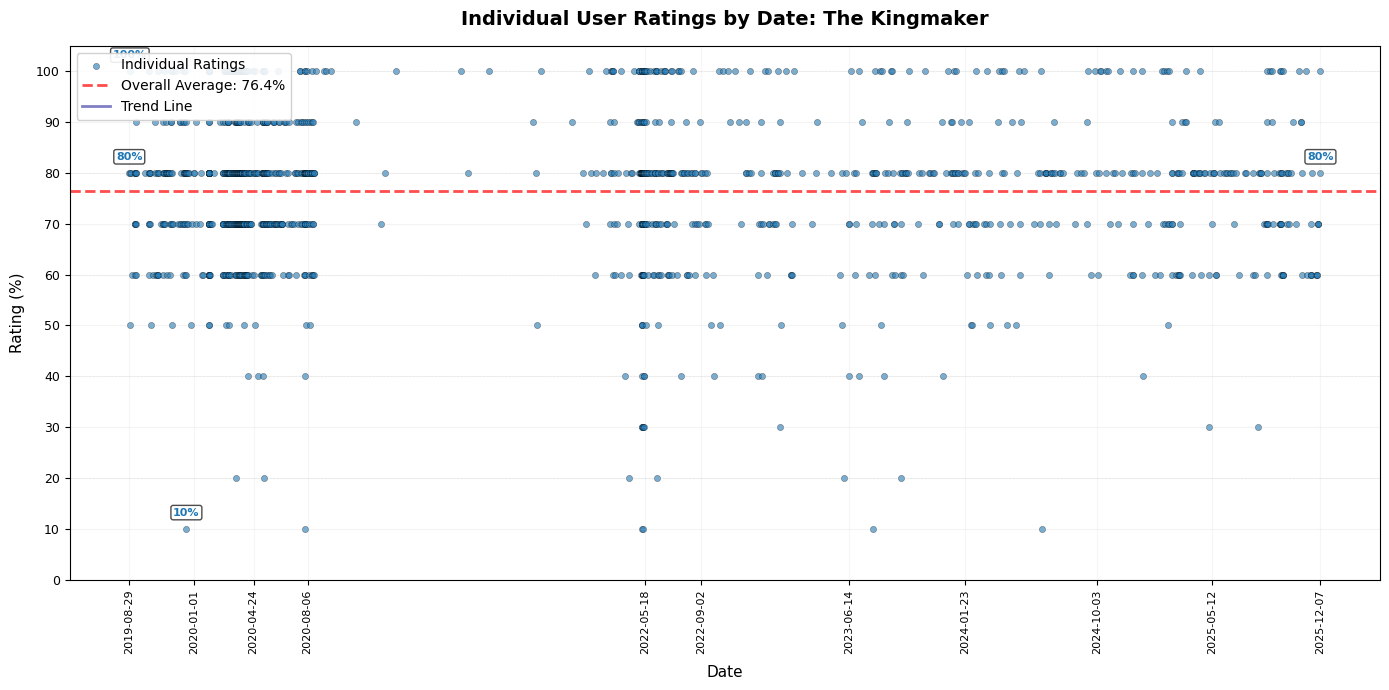


Individual Ratings Scatterplot (Daily) for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total days with reviews: 701
Total reviews: 1464
Overall average rating: 76.4%
Rating range: 10% to 100%
Trend slope: nan (positive = increasing over time)

DAILY NMD SCORES SCATTERPLOT (NO MONTH GROUPING)


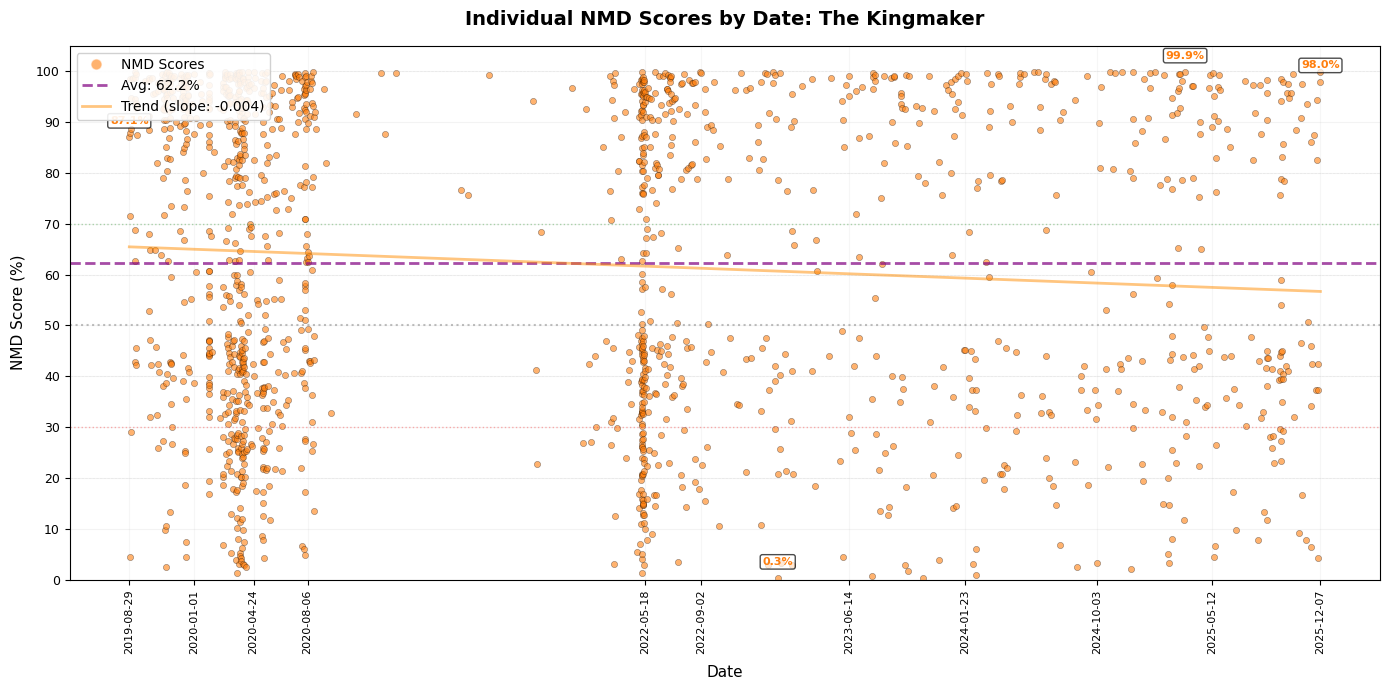


Individual NMD Scores Scatterplot (Daily) for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total days with reviews: 701
Total reviews: 1464
Overall average NMD: 62.24%
NMD range: 0.31% to 99.90%
Trend slope: -0.0038 (positive = NMD increasing over time)

DAILY COMBINED SCATTERPLOTS


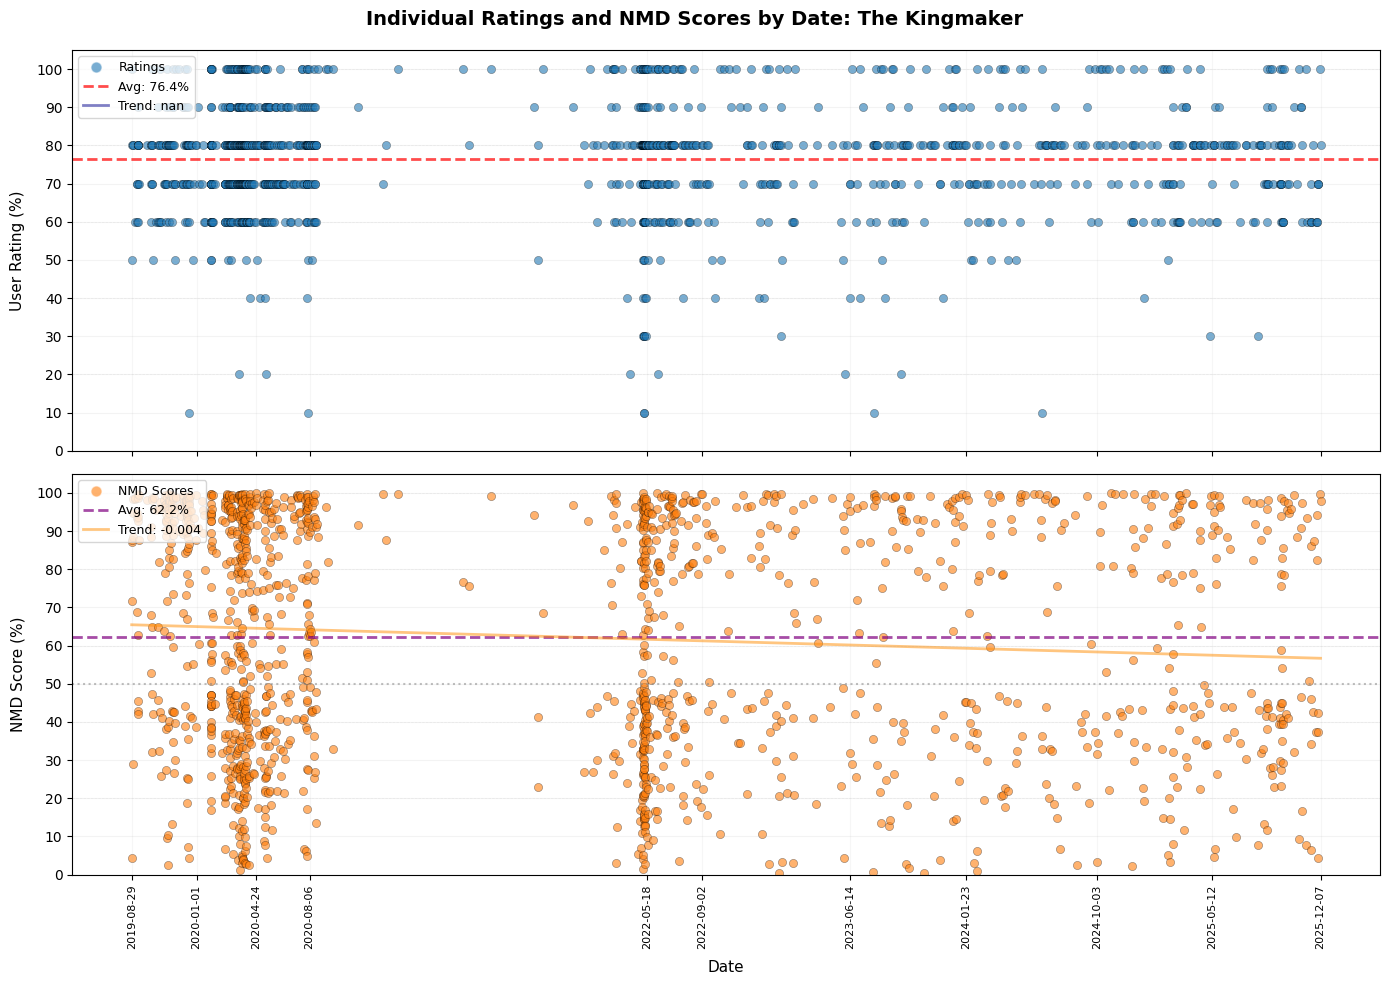


Daily Combined Analysis for 'The Kingmaker':
Date range: 2019-08-29 to 2025-12-07
Total reviews: 1464
Total days with reviews: 701
Average user rating: 76.4% (trend: nan)
Average NMD score: 62.24% (trend: -0.0038)
Correlation between rating and NMD: 0.060
Interpretation: Weak or no correlation


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def create_rating_scatterplot_daily(df, movie_name):
    """
    Create a scatterplot showing individual user ratings over time (daily)
    Each point is an individual review/rating on its actual date
    """
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Check for rating column
    rating_col = 'rating' if 'rating' in df.columns else 'user_rating'
    
    # Ensure date is datetime
    if 'date' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'])
    else:
        print("Error: No 'date' column found in the data")
        print(f"Available columns: {list(df.columns)}")
        return
    
    # Group by review_index to get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        rating_col: 'first',
        'nmd_score': 'mean'
    }).reset_index()
    
    # Sort by date
    unique_reviews = unique_reviews.sort_values('date')
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Convert dates to numeric values for x-axis (days since first date)
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add small jitter to prevent overlapping points on same date
    np.random.seed(42)
    jitter_amount = 0.3  # Days of jitter
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Create scatter plot with SMALLER circles (size reduced from 80 to 40)
    scatter = plt.scatter(unique_reviews['x_jittered'], 
                         unique_reviews[rating_col],
                         s=20,  # SMALLER: Changed from 80 to 40
                         c='#1f77b4',
                         alpha=0.6,
                         edgecolors='black',
                         linewidth=0.3,  # Thinner edge
                         label='Individual Ratings')
    
    # Add horizontal line for overall average
    overall_avg = unique_reviews[rating_col].mean()
    plt.axhline(y=overall_avg, 
                color='red', 
                linestyle='--', 
                linewidth=2,
                alpha=0.7,
                label=f'Overall Average: {overall_avg:.1f}%')
    
    # Add trend line
    z = np.polyfit(unique_reviews['date_numeric'], unique_reviews[rating_col], 1)
    p = np.poly1d(z)
    plt.plot(unique_reviews['date_numeric'].sort_values(), 
             p(unique_reviews['date_numeric'].sort_values()),
             color='darkblue',
             linestyle='-',
             linewidth=2,
             alpha=0.5,
             label='Trend Line')
    
    # Label some key points
    if len(unique_reviews) <= 30:
        # Label all points if there are few
        for i, row in unique_reviews.iterrows():
            plt.annotate(f'{row[rating_col]:.0f}%', 
                        (row['x_jittered'], row[rating_col]),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=7,
                        color='#1f77b4')
    else:
        # Label first, last, min, max, and every Nth point
        first_idx = unique_reviews.index[0]
        last_idx = unique_reviews.index[-1]
        min_idx = unique_reviews[rating_col].idxmin()
        max_idx = unique_reviews[rating_col].idxmax()
        
        for idx in [first_idx, last_idx, min_idx, max_idx]:
            row = unique_reviews.loc[idx]
            plt.annotate(f'{row[rating_col]:.0f}%', 
                        (row['x_jittered'], row[rating_col]),
                        xytext=(0, 8),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='#1f77b4',
                        bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor="white", 
                                alpha=0.7))
    
    # Set up x-axis with actual dates
    # Get unique dates for labeling
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    
    # Convert to numeric positions
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    
    # Format date labels
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    # Determine label frequency
    num_dates = len(date_labels)
    if num_dates > 20:
        # Show every 3rd date label
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        plt.xticks([date_numeric_positions[i] for i in show_indices],
                   [date_label_strings[i] for i in show_indices],
                   rotation=90, ha='center', fontsize=8)
    else:
        # Show all dates
        plt.xticks(date_numeric_positions, date_label_strings,
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis
    plt.ylim(0, 105)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add grid
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.1, axis='x')
    
    # Add reference lines
    for y in [20, 40, 60, 80, 100]:
        plt.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Add legend
    plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # Title and labels
    plt.title(f'Individual User Ratings by Date: {movie_name}', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Date', fontsize=11, labelpad=8)
    plt.ylabel('Rating (%)', fontsize=11, labelpad=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nIndividual Ratings Scatterplot (Daily) for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Overall average rating: {overall_avg:.1f}%")
    print(f"Rating range: {unique_reviews[rating_col].min():.0f}% to {unique_reviews[rating_col].max():.0f}%")
    print(f"Trend slope: {z[0]:.4f} (positive = increasing over time)")


def create_nmd_scatterplot_daily(df, movie_name):
    """
    Create a scatterplot showing individual NMD scores over time (daily)
    Each point is an individual review's average NMD score on its actual date
    """
    # Make a copy
    df = df.copy()
    
    # Check for required columns
    if 'nmd_score' not in df.columns or 'date' not in df.columns:
        print("Error: Missing required columns")
        return
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Group by review_index to get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        'nmd_score': 'mean',
        'rating': 'first'
    }).reset_index()
    
    # Sort by date
    unique_reviews = unique_reviews.sort_values('date')
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Convert dates to numeric values
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add jitter
    np.random.seed(42)
    jitter_amount = 0.3
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Create scatter plot with SMALLER circles
    scatter = plt.scatter(unique_reviews['x_jittered'], 
                         unique_reviews['nmd_score'],
                         s=20,  # SMALLER: Changed from 80 to 40
                         c='#ff7f0e',
                         alpha=0.6,
                         edgecolors='black',
                         linewidth=0.3,  # Thinner edge
                         label='NMD Scores')
    
    # Add horizontal lines
    overall_avg_nmd = unique_reviews['nmd_score'].mean()
    plt.axhline(y=overall_avg_nmd, 
                color='purple', 
                linestyle='--', 
                linewidth=2,
                alpha=0.7,
                label=f'Overall Average: {overall_avg_nmd:.1f}%')
    
    plt.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    plt.axhline(y=70, color='green', linestyle=':', linewidth=1, alpha=0.3)
    plt.axhline(y=30, color='red', linestyle=':', linewidth=1, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(unique_reviews['date_numeric'], unique_reviews['nmd_score'], 1)
    p = np.poly1d(z)
    plt.plot(unique_reviews['date_numeric'].sort_values(), 
             p(unique_reviews['date_numeric'].sort_values()),
             color='darkorange',
             linestyle='-',
             linewidth=2,
             alpha=0.5,
             label='Trend Line')
    
    # Label key points
    if len(unique_reviews) <= 30:
        for i, row in unique_reviews.iterrows():
            plt.annotate(f'{row["nmd_score"]:.0f}%', 
                        (row['x_jittered'], row['nmd_score']),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=7,
                        color='#ff7f0e')
    else:
        first_idx = unique_reviews.index[0]
        last_idx = unique_reviews.index[-1]
        min_idx = unique_reviews['nmd_score'].idxmin()
        max_idx = unique_reviews['nmd_score'].idxmax()
        
        for idx in [first_idx, last_idx, min_idx, max_idx]:
            row = unique_reviews.loc[idx]
            plt.annotate(f'{row["nmd_score"]:.1f}%', 
                        (row['x_jittered'], row['nmd_score']),
                        xytext=(0, 8),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        fontweight='bold',
                        color='#ff7f0e',
                        bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor="white", 
                                alpha=0.7))
    
    # Set up x-axis
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    num_dates = len(date_labels)
    if num_dates > 20:
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        plt.xticks([date_numeric_positions[i] for i in show_indices],
                   [date_label_strings[i] for i in show_indices],
                   rotation=90, ha='center', fontsize=8)
    else:
        plt.xticks(date_numeric_positions, date_label_strings,
                   rotation=90, ha='center', fontsize=9)
    
    # Set y-axis
    plt.ylim(0, 105)
    y_ticks = list(range(0, 101, 10))
    plt.yticks(y_ticks, fontsize=9)
    
    # Add grid and reference lines
    plt.grid(True, alpha=0.15, axis='y')
    plt.grid(True, alpha=0.1, axis='x')
    for y in [20, 40, 60, 80, 100]:
        plt.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='NMD Scores',
               markerfacecolor='#ff7f0e', markersize=8, alpha=0.6),  # Smaller marker in legend
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2, 
               label=f'Avg: {overall_avg_nmd:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkorange', linewidth=2,
               label=f'Trend (slope: {z[0]:.3f})', alpha=0.5),
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)
    
    # Title and labels
    plt.title(f'Individual NMD Scores by Date: {movie_name}', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Date', fontsize=11, labelpad=8)
    plt.ylabel('NMD Score (%)', fontsize=11, labelpad=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nIndividual NMD Scores Scatterplot (Daily) for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Overall average NMD: {overall_avg_nmd:.2f}%")
    print(f"NMD range: {unique_reviews['nmd_score'].min():.2f}% to {unique_reviews['nmd_score'].max():.2f}%")
    print(f"Trend slope: {z[0]:.4f} (positive = NMD increasing over time)")


def create_combined_scatterplot_daily(df, movie_name):
    """
    Create side-by-side scatterplots for ratings and NMD (daily)
    """
    # Make a copy
    df = df.copy()
    
    # Check for required columns
    rating_col = 'rating' if 'rating' in df.columns else 'user_rating'
    
    if 'nmd_score' not in df.columns or 'date' not in df.columns:
        print("Error: Missing required columns")
        return
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Get unique reviews
    unique_reviews = df.groupby(['review_index', 'username', 'date']).agg({
        rating_col: 'first',
        'nmd_score': 'mean'
    }).reset_index()
    
    # Sort and prepare data
    unique_reviews = unique_reviews.sort_values('date')
    unique_reviews['date_numeric'] = (unique_reviews['date'] - unique_reviews['date'].min()).dt.days
    
    # Add jitter
    np.random.seed(42)
    jitter_amount = 0.3
    unique_reviews['x_jittered'] = unique_reviews['date_numeric'] + np.random.uniform(
        -jitter_amount, jitter_amount, size=len(unique_reviews)
    )
    
    # Get date labels for x-axis
    unique_dates = unique_reviews['date'].dt.normalize().unique()
    date_labels = pd.Series(unique_dates).sort_values()
    date_numeric_positions = [(date - unique_reviews['date'].min()).days for date in date_labels]
    date_label_strings = [date.strftime('%Y-%m-%d') for date in date_labels]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot 1: User Ratings with SMALLER circles
    scatter1 = ax1.scatter(unique_reviews['x_jittered'], 
                          unique_reviews[rating_col],
                          s=35,  # SMALLER: Changed from 70 to 35
                          c='#1f77b4',
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.3,  # Thinner edge
                          label='Ratings')
    
    avg_rating = unique_reviews[rating_col].mean()
    ax1.axhline(y=avg_rating, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add trend line for ratings
    z1 = np.polyfit(unique_reviews['date_numeric'], unique_reviews[rating_col], 1)
    p1 = np.poly1d(z1)
    ax1.plot(unique_reviews['date_numeric'].sort_values(), 
             p1(unique_reviews['date_numeric'].sort_values()),
             color='darkblue',
             linestyle='-',
             linewidth=2,
             alpha=0.5)
    
    # Plot 2: NMD Scores with SMALLER circles
    scatter2 = ax2.scatter(unique_reviews['x_jittered'], 
                          unique_reviews['nmd_score'],
                          s=35,  # SMALLER: Changed from 70 to 35
                          c='#ff7f0e',
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.3,  # Thinner edge
                          label='NMD Scores')
    
    avg_nmd = unique_reviews['nmd_score'].mean()
    ax2.axhline(y=avg_nmd, color='purple', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Add trend line for NMD
    z2 = np.polyfit(unique_reviews['date_numeric'], unique_reviews['nmd_score'], 1)
    p2 = np.poly1d(z2)
    ax2.plot(unique_reviews['date_numeric'].sort_values(), 
             p2(unique_reviews['date_numeric'].sort_values()),
             color='darkorange',
             linestyle='-',
             linewidth=2,
             alpha=0.5)
    
    # Configure plots
    for ax in [ax1, ax2]:
        ax.set_ylim(0, 105)
        ax.set_yticks(range(0, 101, 10))
        ax.grid(True, alpha=0.15, axis='y')
        ax.grid(True, alpha=0.1, axis='x')
        
        # Add reference lines
        for y in [20, 40, 60, 80, 100]:
            ax.axhline(y=y, color='gray', linestyle='--', alpha=0.1, linewidth=0.5)
    
    # Set x-axis labels
    num_dates = len(date_labels)
    if num_dates > 20:
        show_indices = list(range(0, num_dates, max(3, num_dates // 10)))
        ax2.set_xticks([date_numeric_positions[i] for i in show_indices])
        ax2.set_xticklabels([date_label_strings[i] for i in show_indices],
                           rotation=90, ha='center', fontsize=8)
    else:
        ax2.set_xticks(date_numeric_positions)
        ax2.set_xticklabels(date_label_strings,
                           rotation=90, ha='center', fontsize=9)
    
    # Add legends with smaller markers
    from matplotlib.lines import Line2D
    legend1_elements = [
        Line2D([0], [0], marker='o', color='w', label='Ratings',
               markerfacecolor='#1f77b4', markersize=8, alpha=0.6),  # Smaller
        Line2D([0], [0], color='red', linestyle='--', linewidth=2,
               label=f'Avg: {avg_rating:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkblue', linewidth=2,
               label=f'Trend: {z1[0]:.3f}', alpha=0.5),
    ]
    
    legend2_elements = [
        Line2D([0], [0], marker='o', color='w', label='NMD Scores',
               markerfacecolor='#ff7f0e', markersize=8, alpha=0.6),  # Smaller
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2,
               label=f'Avg: {avg_nmd:.1f}%', alpha=0.7),
        Line2D([0], [0], color='darkorange', linewidth=2,
               label=f'Trend: {z2[0]:.3f}', alpha=0.5),
    ]
    
    ax1.legend(handles=legend1_elements, loc='upper left', fontsize=9)
    ax2.legend(handles=legend2_elements, loc='upper left', fontsize=9)
    
    # Set labels
    ax1.set_ylabel('User Rating (%)', fontsize=11, labelpad=8)
    ax2.set_ylabel('NMD Score (%)', fontsize=11, labelpad=8)
    ax2.set_xlabel('Date', fontsize=11, labelpad=8)
    
    fig.suptitle(f'Individual Ratings and NMD Scores by Date: {movie_name}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()
    
    # Print summary
    print(f"\nDaily Combined Analysis for '{movie_name}':")
    print(f"Date range: {unique_reviews['date'].min().strftime('%Y-%m-%d')} to {unique_reviews['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total reviews: {len(unique_reviews)}")
    print(f"Total days with reviews: {len(date_labels)}")
    print(f"Average user rating: {avg_rating:.1f}% (trend: {z1[0]:.4f})")
    print(f"Average NMD score: {avg_nmd:.2f}% (trend: {z2[0]:.4f})")
    correlation = unique_reviews[rating_col].corr(unique_reviews['nmd_score'])
    print(f"Correlation between rating and NMD: {correlation:.3f}")
    
    if correlation > 0.7:
        print("Interpretation: Strong positive correlation - ratings and NMD scores move together")
    elif correlation > 0.3:
        print("Interpretation: Moderate positive correlation")
    elif correlation > -0.3:
        print("Interpretation: Weak or no correlation")
    elif correlation > -0.7:
        print("Interpretation: Moderate negative correlation")
    else:
        print("Interpretation: Strong negative correlation - ratings and NMD scores move opposite")


# Optional: Add a function with even smaller circles if needed
def create_scatterplot_smaller(df, movie_name, metric='rating', circle_size=20):
    """
    Create scatterplot with customizable circle size
    """
    # Similar code as above, but with parameterized circle size
    # You can add this if you want even more control


# Main execution
if __name__ == "__main__":
    print("=" * 70)
    print("DAILY USER RATINGS SCATTERPLOT (NO MONTH GROUPING)")
    print("=" * 70)
    create_rating_scatterplot_daily(df_nmd.copy(), "The Kingmaker")
    
    print("\n" + "=" * 70)
    print("DAILY NMD SCORES SCATTERPLOT (NO MONTH GROUPING)")
    print("=" * 70)
    create_nmd_scatterplot_daily(df_nmd.copy(), "The Kingmaker")
    
    print("\n" + "=" * 70)
    print("DAILY COMBINED SCATTERPLOTS")
    print("=" * 70)
    create_combined_scatterplot_daily(df_nmd.copy(), "The Kingmaker")

In [38]:
df_final = pd.read_csv("./Narrative-Metric Disconnect/The Kingmaker/review_summary.csv")

In [39]:
df_final = df_final.rename(columns={'nmd_score': 'mss'})
df_final['nmd_difference'] = abs(df_final['mss'] - df_final['user_rating'])

In [41]:
def categorize_nmd(diff):
    if diff <= 10:
        return 'Low Significance'
    elif diff <= 25:
        return 'Moderate Significance'
    else:
        return 'High Significance'

df_final['significance_category'] = df_final['nmd_difference'].apply(categorize_nmd)

overall_r = df_final['user_rating'].corr(df_final['mss'])

correlation_by_cat = df_final.groupby('significance_category', group_keys=False).apply(
    lambda x: x['user_rating'].corr(x['mss'])
)

print(f"--- GLOBAL ANALYSIS ---")
print(f"Overall Pearson r: {overall_r:.3f}")
print(f"\n--- ANALYSIS BY NMD LEVEL ---")
print(correlation_by_cat)

# 4. Check if we have the 'Collapse'
high_sig_r = correlation_by_cat.get('High Significance', 0)
if high_sig_r < 0.2:
    print("\nResult: Relationship Collapse confirmed in High Significance group.")

--- GLOBAL ANALYSIS ---
Overall Pearson r: 0.060

--- ANALYSIS BY NMD LEVEL ---
significance_category
High Significance       -0.378163
Low Significance         0.947289
Moderate Significance    0.588983
dtype: float64

Result: Relationship Collapse confirmed in High Significance group.


C:\Users\joshu\AppData\Local\Temp\ipykernel_18712\1037291818.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_cat = df_final.groupby('significance_category', group_keys=False).apply(


In [42]:
df_final

,review_index,username,review_date,user_rating,source,num_sentences,sum_score,mss,avg_sentiment_score,positive_percentage,nmd_difference,significance_category
0,0,VoNiTo101,2022-05-06 00:00:00.000,90.0,imdb,5,2.294026,72.940263,0.845795,80.000000,17.059737,Moderate Significance
1,1,brockfal,2022-05-10 00:00:00.000,80.0,imdb,5,-0.300299,46.997011,0.828601,60.000000,33.002989,High Significance
2,2,DennisGillEndor,2019-12-05 00:00:00.000,90.0,imdb,4,1.479862,68.498277,0.841766,75.000000,21.501723,Moderate Significance
3,3,andrewcollins-86653,2021-10-29 00:00:00.000,100.0,imdb,4,1.477292,68.466151,0.901964,75.000000,31.533849,High Significance
4,4,wmurch3,2022-06-08 00:00:00.000,100.0,imdb,6,2.888182,74.068181,0.779259,83.333333,25.931819,High Significance
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1543,Elizabeth Weitzman,2019-10-31 00:00:00.000,NaN,rt,1,0.964074,98.203698,0.964074,100.000000,NaN,High Significance
1460,1544,Musanna Ahmed,2019-10-11 00:00:00.000,NaN,rt,1,0.974241,98.712063,0.974241,100.000000,NaN,High Significance
1461,1545,Eric Kohn,2019-09-05 00:00:00.000,NaN,rt,1,0.971806,98.590323,0.971806,100.000000,NaN,High Significance
1462,1546,Todd McCarthy,2019-09-01 00:00:00.000,NaN,rt,1,0.895260,94.763002,0.895260,100.000000,NaN,High Significance


In [44]:
import pandas as pd

# 1. Calculate the percentage distribution
# This prints the specific line you asked for
category_dist = df_final['significance_category'].value_counts(normalize=True) * 100

print("--- DISTRIBUTION RESULTS ---")
print(category_dist)

# 2. To print it as a clean table for your report with all your findings:
print("\n--- TABLE 1 PREVIEW ---")
summary_table = pd.DataFrame({
    'Percentage (%)': df_final['significance_category'].value_counts(normalize=True) * 100,
    'Pearson r': df_final.groupby('significance_category').apply(
        lambda x: x['user_rating'].corr(x['mss']), include_groups=False
    )
})

# Adding the 'NMD Magnitude Range' as a column for clarity
magnitude_map = {
    'Low Significance': '0-10%',
    'Moderate Significance': '11-25%',
    'High Significance': '> 25%'
}
summary_table['NMD Magnitude Range'] = summary_table.index.map(magnitude_map)

# Print final result
print(summary_table[['NMD Magnitude Range', 'Percentage (%)', 'Pearson r']].round(2))

--- DISTRIBUTION RESULTS ---
significance_category
High Significance        58.811475
Moderate Significance    24.726776
Low Significance         16.461749
Name: proportion, dtype: float64

--- TABLE 1 PREVIEW ---
                      NMD Magnitude Range  Percentage (%)  Pearson r
significance_category                                               
High Significance                   > 25%           58.81      -0.38
Low Significance                    0-10%           16.46       0.95
Moderate Significance              11-25%           24.73       0.59


In [ ]:
df_final.to_csv("./Narrative-Metric Disconnect/The Kingmaker/final_results.csv", index=False)